In [123]:
import numpy as np
import matplotlib.pyplot as plt
import gender_guesser.detector as gender
import pandas as pd
import math
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [124]:
g_users = pd.read_csv("data/users.csv")
f_users = pd.read_csv("data/fusers.csv")
g_users.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,created_at,url,...,profile_sidebar_fill_color,profile_background_image_url,profile_background_color,profile_link_color,utc_offset,protected,verified,description,updated,dataset
0,3610511,Davide Dellacasa,braddd,20370,5470,2385,145,52,Fri Apr 06 10:58:22 +0000 2007,http://braddd.tumblr.com,...,FFF7CC,http://a0.twimg.com/profile_background_images/...,BADFCD,FF0000,3600.0,NaN,NaN,Founder of http://www.screenweek.it & http://w...,2015-02-14 10:54:49,E13
1,5656162,Simone Economo,eKoeS,3131,506,381,9,40,Mon Apr 30 15:08:42 +0000 2007,http://www.lineheight.net/,...,DDEEF6,http://a0.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,3600.0,NaN,NaN,BSc degree (cum laude) in Computer Engineering...,2015-02-14 10:54:49,E13
2,5682702,tacone,tacone_,4024,264,87,323,16,Tue May 01 11:53:40 +0000 2007,http://t.co/LKrl1dZE,...,000000,http://a0.twimg.com/profile_background_images/...,1A1B1F,2FC2EF,3600.0,NaN,NaN,Cogito ergo bestemmio.,2015-02-14 10:54:49,E13
3,6067292,alesaura,alesstar,40586,640,622,1118,32,Tue May 15 16:55:16 +0000 2007,http://alesstar.wordpress.com/,...,95E8EC,http://a0.twimg.com/images/themes/theme4/bg.gif,0099B9,0099B9,3600.0,NaN,NaN,"Se la vita ti dà sarde, scapocciale!",2015-02-14 10:54:49,E13
4,6015122,Angelo,PerDiletto,2016,62,64,13,0,Sun May 13 19:52:00 +0000 2007,http://www.flickr.com/per_diletto,...,F6F6F6,http://a0.twimg.com/images/themes/theme18/bg.gif,ACDED6,038543,3600.0,NaN,NaN,Je me souviens,2015-02-14 10:54:49,E13


In [125]:
data=pd.concat([f_users,g_users],ignore_index=True)

In [126]:
data_object=data.select_dtypes(include=['object'])
data['dataset']=data.dataset.map({'INT':0,'E13':1})

### Data Preprocessing

In [127]:
data[data.duplicated()]   #checking for duplicated values

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,created_at,url,...,profile_sidebar_fill_color,profile_background_image_url,profile_background_color,profile_link_color,utc_offset,protected,verified,description,updated,dataset


### forward fill-will fill with the current row values if the next row have null value
### backward fill - will fill with the current row values if the previous row have null value

In [128]:
fill_cols=['time_zone','utc_offset','description','location']
for i in fill_cols:
    data[i]=data[i].fillna(method='ffill')
    data[i]=data[i].fillna(method='bfill')

In [129]:
fillna_cols=['profile_use_background_image','profile_background_tile','geo_enabled','default_profile_image','default_profile']
for i in fillna_cols:
    data[i]=data[i].fillna(0)

### Function to convert color code into RGB format

In [130]:
def hex_to_rgb(value):
    lv = len(value)
    return tuple(int(value[i:i+lv//3], 16) for i in range(0, lv, lv//3))

In [131]:
color_columns=['profile_text_color','profile_sidebar_border_color','profile_sidebar_fill_color','profile_background_color',
               'profile_link_color']
for i in color_columns:
    data[i]=data[i].apply(hex_to_rgb)

## Forming new columns that contains the R,G,B value of each of the 5 columns in 'color_columns', Thus forming 15 new columns...

In [132]:
abcde=pd.DataFrame()
for i in color_columns:
    abcdef=pd.DataFrame(data[i].tolist(), columns=[str(i)+'_red',str(i)+'_green',str(i)+'_blue'])
    abcde=pd.concat([abcdef,abcde],axis=1)
    

### concating new columns with the original dataframe

In [133]:
data=pd.concat([data,abcde],axis=1)
data.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,created_at,url,...,profile_background_color_blue,profile_sidebar_fill_color_red,profile_sidebar_fill_color_green,profile_sidebar_fill_color_blue,profile_sidebar_border_color_red,profile_sidebar_border_color_green,profile_sidebar_border_color_blue,profile_text_color_red,profile_text_color_green,profile_text_color_blue
0,370098498,pirfectmoses,pirfectmoses,24,4,588,16,0,Thu Sep 08 13:20:35 +0000 2011,NaN,...,238,221,238,246,255,255,255,51,51,51
1,37384589,SAK Nair,bsknair1967,656,57,693,597,0,Sun May 03 07:35:13 +0000 2009,NaN,...,237,221,238,246,192,222,237,51,51,51
2,72110028,Deepak,dedjven,1234,15,104,1150,0,Sun Sep 06 19:50:08 +0000 2009,NaN,...,22,239,239,239,238,238,238,51,51,51
3,82885728,Marcos Vinicius,BrowAlves,573,14,227,530,0,Fri Oct 16 14:02:48 +0000 2009,NaN,...,237,221,238,246,192,222,237,31,29,31
4,110120789,Shri Kant Kanaujia,kanaujiask,675,18,519,653,0,Sun Jan 31 12:08:41 +0000 2010,NaN,...,237,221,238,246,192,222,237,51,51,51


### dropping previous columns in 'color_columns' because it's no longer in use

In [134]:
data=data.drop(color_columns,axis=1)
data.shape

(2818, 44)

### Since the data is nominal, we cannot use Label Encoder
### Thus we'll use get_dummies under pandas package

In [135]:
dummy_features=['lang','time_zone']
for i in dummy_features:
    xyz=pd.get_dummies(data[i])
    data=pd.concat([data,xyz],axis=1)

### Here we'll use Label Encoder in utc_offset coolumn because it is an ordinal data

In [136]:
lbl=LabelEncoder()
data.utc_offset=lbl.fit_transform(data.utc_offset)

In [137]:
data=data.drop(['protected', 'verified','url','profile_banner_url','lang','time_zone','id'], axis=1)

In [138]:
data['created_at']=pd.to_datetime(data.created_at)
data['created_at_minute']=data.created_at.dt.minute
data["created_at_hour"]=data.created_at.dt.hour
data['created_on_date']=data.created_at.dt.day
data['created_in_month']=data.created_at.dt.month
data['created_in_year']=data.created_at.dt.year

In [139]:
data.created_in_year=lbl.fit_transform(data.created_in_year)
data.updated=lbl.fit_transform(data.updated)
data=data.drop('created_at',axis=1)

In [140]:
object_types=['profile_background_image_url','description','profile_image_url_https','profile_image_url','location',
              'profile_background_image_url_https']
data=data.drop(object_types,axis=1)  

### assigning a sex code to each sample on the basis of it's name

In [141]:
def predict_sex(name):
    sex_predictor=gender.Detector(case_sensitive=False)
    first_name=name.str.split(' ').str.get(0)
    sex=first_name.apply(sex_predictor.get_gender)
    sex_dict={'female':-2,'mostly_female':-1,'unknown':0,'mostly_male':1,'male':2,'andy':3}
    sex_code=sex.map(sex_dict).astype(int)
    return(sex_code)
data['sex_code']=predict_sex(data.name)

In [142]:
data=data.drop(['screen_name','name'],axis=1)
data.shape

(2818, 75)

### Feature scaling using MinMaxScalar

In [143]:
minmax=MinMaxScaler(feature_range=(1,100))

In [144]:
feature_scaled=['friends_count','statuses_count','followers_count','favourites_count']
for i in feature_scaled:
    a=data[i]
    a=a.values
    a=a.reshape(-1,1)
    a=(minmax.fit_transform(a)).astype(float)
    data[i]=a

C:\Users\HimanshuKumar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\HimanshuKumar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\HimanshuKumar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\HimanshuKumar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [145]:
y=data['dataset']
data=data.drop('dataset',axis=1)
x=data.copy(deep=True)

## Features Selection
#### TYPES: Filter Methods, Wrapper Methods, Embedded Methods
##### Filter Methods: Filter feature selection methods apply a statistical measure to assign a scoring to each feature e.g.  Chi squared test, information gain and correlation coefficient scores etc.
###### Wrapper methods consider the selection of a set of features as a search problem, where different combinations are prepared, evaluated and compared to other combinations. e.g.  recursive feature elimination algorithm.
###### Embedded methods learn which features best contribute to the accuracy of the model while the model is being created. The most common type of embedded feature selection methods are regularization methods. e.g. LASSO, Elastic Net and Ridge Regression

### Feature selection using SelectFromModel and tree based feature selection

In [146]:
rf=RandomForestClassifier(random_state=10)
rf.fit(x,y)
important_features=[]
important_features=(rf.feature_importances_).tolist()
model=SelectFromModel(rf,prefit=True)
X_new=model.transform(x)
X_new.shape

C:\Users\HimanshuKumar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(2818, 10)

In [147]:
model.get_support()            

array([False, False, False,  True,  True, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
        True, False])

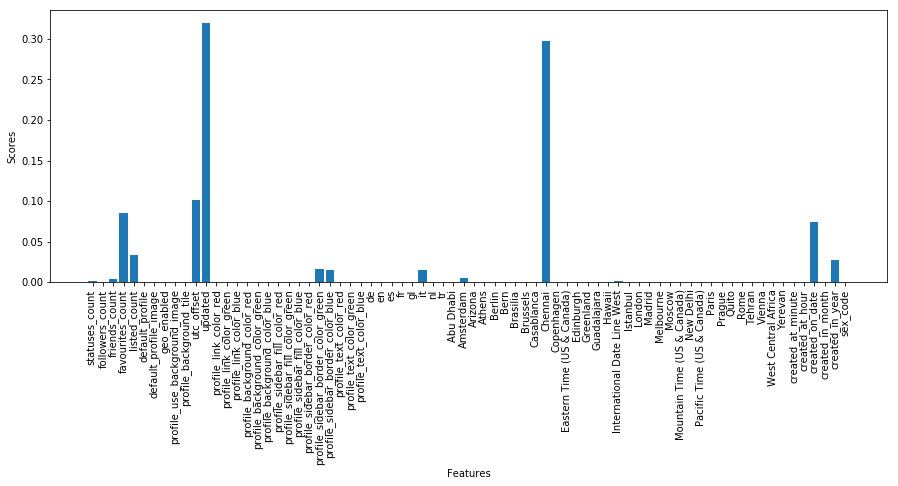

In [148]:
plt.subplots(figsize=(15,5))
y_pos = np.arange(len(x.columns))
plt.bar(y_pos,important_features,align='center')
plt.xlabel("Features")
plt.ylabel("Scores")
plt.xticks(y_pos,x.columns, rotation=90,fontsize=10)
plt.show()

In [149]:
selected_columns=[]
selected_columns=data.columns.tolist()

In [150]:
features_dict={}
features_dict=dict(zip(selected_columns,important_features))
important_features_1=pd.Series(features_dict)
important_features_1.nlargest(10)

updated                               0.319241
Chennai                               0.297591
utc_offset                            0.101372
favourites_count                      0.084926
created_on_date                       0.073789
listed_count                          0.033211
created_in_year                       0.027870
profile_sidebar_border_color_green    0.016220
profile_sidebar_border_color_blue     0.015465
it                                    0.014567
dtype: float64

In [151]:
#sorted_feature_dict = sorted(features_dict.items(), key=lambda kv: kv[1],reverse=True)

#### mutual_info_classif works by selecting the best features based on univariate statistical tests

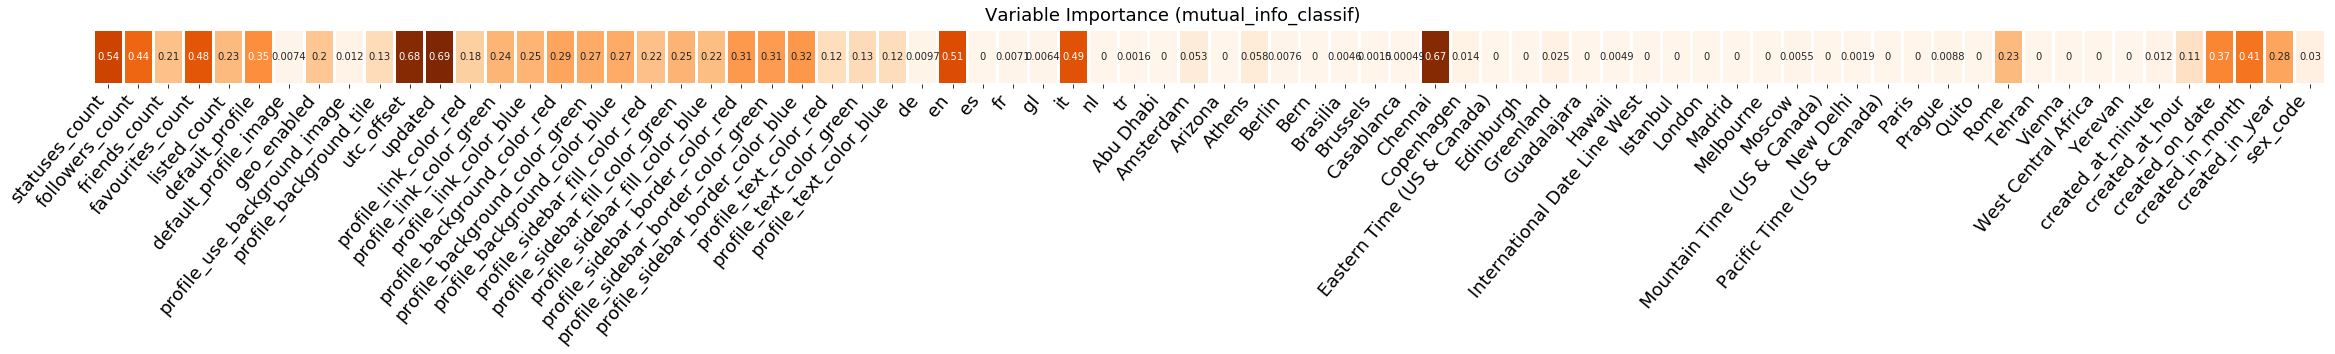

In [152]:
features_mutual_information = mutual_info_classif(x,y)
plt.subplots(1, figsize=(40, 1))
sns.heatmap(features_mutual_information[:, np.newaxis].T, cmap='Oranges', cbar=False, linewidths=2, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(data.columns, rotation=50, ha='right', fontsize=18)
plt.suptitle("Variable Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.5)

In [153]:
from sklearn.feature_selection import SelectKBest
X__new=SelectKBest(mutual_info_classif,k=10).fit_transform(x,y)
X__new.shape

(2818, 10)

In [154]:
features_dict_2={}
features_dict_2=dict(zip(selected_columns,features_mutual_information))
important_features_2=pd.Series(features_dict_2)
important_features_2.nlargest(10)

updated             0.692018
utc_offset          0.675282
Chennai             0.673717
statuses_count      0.538194
en                  0.507683
it                  0.494469
favourites_count    0.482196
followers_count     0.439079
created_in_month    0.407212
created_on_date     0.367255
dtype: float64

#### Using pearson's correlation to find the dependecy between two variables

In [155]:
data1=data.copy(deep=True)
data1['target']=y
important_features_3=data1.corr() # corr() is used to find the pairwise correlation of all columns in the dataframe
# correlation types: "pearson", "kendal", "spearman".
important_features_3=important_features_3.iloc[-1,:]
important_features_3=important_features_3.nlargest(10).index.tolist()

In [156]:
data1.corr().iloc[20:,:]

,statuses_count,followers_count,friends_count,favourites_count,listed_count,default_profile,default_profile_image,geo_enabled,profile_use_background_image,profile_background_tile,...,Vienna,West Central Africa,Yerevan,created_at_minute,created_at_hour,created_on_date,created_in_month,created_in_year,sex_code,target
profile_sidebar_fill_color_blue,-0.123917,-0.072420,0.017917,-0.037090,-0.061397,0.447202,0.018951,-0.253635,0.058290,-0.223312,...,-0.006414,-0.011290,0.003889,0.044784,-0.070554,0.187836,-0.038799,0.283555,-0.019646,-0.336728
profile_sidebar_border_color_red,-0.071402,-0.046193,0.007782,-0.011515,-0.038665,0.150137,0.006362,-0.102966,-0.030471,-0.036540,...,0.016404,-0.007274,-0.026742,0.011331,0.013387,0.103077,-0.025802,0.096203,-0.025453,-0.115760
profile_sidebar_border_color_green,-0.116712,-0.057147,0.008246,-0.018094,-0.083078,0.314334,0.013321,-0.186358,0.002716,-0.180353,...,0.009559,-0.018511,-0.009321,0.025663,-0.004940,0.179808,-0.033589,0.175080,-0.029556,-0.237986
profile_sidebar_border_color_blue,-0.142213,-0.058679,0.003740,-0.026976,-0.089993,0.411200,0.017426,-0.219429,0.016154,-0.212368,...,0.004854,-0.028167,0.000694,0.039244,-0.027910,0.211474,-0.038171,0.231866,-0.037378,-0.309564
profile_text_color_red,0.108815,0.025894,-0.007769,0.032853,0.009898,-0.275050,-0.011656,0.149827,-0.043724,0.158275,...,-0.007131,0.031641,0.001956,-0.022868,0.030292,-0.135120,0.054855,-0.162283,0.004491,0.208910
profile_text_color_green,0.008394,0.033232,-0.027416,-0.002207,0.000045,-0.211039,-0.008943,0.124241,-0.003937,0.091568,...,-0.005472,0.027661,-0.023208,-0.022906,0.040192,-0.098155,0.031557,-0.123095,0.038162,0.159574
profile_text_color_blue,0.055550,0.032441,0.012032,0.059165,0.004163,-0.217472,-0.009216,0.150850,-0.068452,0.155156,...,-0.005639,0.007716,0.022477,-0.018802,0.021831,-0.100196,0.050818,-0.125269,0.023077,0.163786
de,0.008075,-0.000696,-0.011182,-0.003402,0.000206,-0.033555,-0.001422,-0.015627,0.003863,0.022975,...,-0.000870,-0.001950,-0.000502,0.040272,-0.007384,0.001335,-0.025816,0.001622,-0.005566,0.025321
en,-0.234323,-0.039213,0.002995,-0.153178,-0.044466,0.651330,-0.016898,-0.469946,0.114792,-0.389983,...,0.008746,-0.078152,-0.020129,0.092143,-0.117014,0.487844,-0.167209,0.356711,-0.152339,-0.887943
es,0.009761,-0.001540,-0.000599,0.004122,0.006544,-0.020393,0.103621,0.002421,0.009075,0.016398,...,-0.002044,-0.004579,-0.001179,-0.002452,0.011658,-0.079727,-0.016997,-0.049006,0.031127,0.048082


In [164]:
X___new=pd.DataFrame()
for i in important_features_3:
    X___new=pd.concat([X___new,data1[i]],axis=1)

In [165]:
final_features=['statuses_count','geo_enabled','profile_background_tile','Rome']

In [166]:
X____new=pd.DataFrame()
for j in final_features:
    X____new=pd.concat([X____new,x[j]],axis=1)
X____new.shape

(2818, 4)

In [175]:
x_train,x_test,y_train,y_test = train_test_split(X____new,y, test_size = 0.20,
                                                 random_state=10)

### Confusion Matrix

In [176]:
def cm(y_test,pred):
    c=confusion_matrix(y_test, pred)
    print(c)

In [179]:
names = ["KNN", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
         "SVM"]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(max_iter = 100),
    SVC()
]

models = zip(names, classifiers)

for name, m in models:
    
    m.fit(x_train,y_train)
    r=recall_score(y_test,m.predict(x_test))
    print('model:',name)
    print('recall_score:%.2f,accuracy_score:%.2f'%(r,m.score(x_test,y_test)))
    cm(y_test,m.predict(x_test))
    print('\n')

model: KNN
recall_score:0.97,accuracy_score:0.98
[[270   3]
 [  9 282]]


model: Decision Tree
recall_score:0.96,accuracy_score:0.97
[[268   5]
 [ 13 278]]


model: Random Forest
recall_score:0.96,accuracy_score:0.97
[[266   7]
 [ 11 280]]


model: Logistic Regression
recall_score:0.89,accuracy_score:0.95
[[273   0]
 [ 31 260]]


model: SGD Classifier
recall_score:0.93,accuracy_score:0.96
[[273   0]
 [ 21 270]]




C:\Users\HimanshuKumar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\HimanshuKumar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HimanshuKumar\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\HimanshuKumar\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma wil

model: SVM
recall_score:0.92,accuracy_score:0.96
[[273   0]
 [ 22 269]]


